In [72]:
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/fraud-detection/creditcard.csv


In [73]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    classification_report, confusion_matrix,
    roc_auc_score, precision_recall_curve,auc, 
    f1_score, precision_score, recall_score ,accuracy_score
)

from sklearn.impute import SimpleImputer
from imblearn.under_sampling import RandomUnderSampler, TomekLinks
from imblearn.over_sampling import SMOTE, BorderlineSMOTE, ADASYN
from imblearn.pipeline import Pipeline as ImbPipeline

import xgboost as xgb
from catboost import CatBoostClassifier
import lightgbm as lgb
from sklearn.ensemble import StackingClassifier
from sklearn.linear_model import LogisticRegression

import warnings
warnings.filterwarnings('ignore')

In [74]:
#Load the dataset and show the first 5 rows
df = pd.read_csv('/kaggle/input/fraud-detection/creditcard.csv')
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [75]:
#Show the last 5 rows
df.tail()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
284802,172786.0,-11.881118,10.071785,-9.834783,-2.066656,-5.364473,-2.606837,-4.918215,7.305334,1.914428,...,0.213454,0.111864,1.014480,-0.509348,1.436807,0.250034,0.943651,0.823731,0.77,0
284803,172787.0,-0.732789,-0.055080,2.035030,-0.738589,0.868229,1.058415,0.024330,0.294869,0.584800,...,0.214205,0.924384,0.012463,-1.016226,-0.606624,-0.395255,0.068472,-0.053527,24.79,0
284804,172788.0,1.919565,-0.301254,-3.249640,-0.557828,2.630515,3.031260,-0.296827,0.708417,0.432454,...,0.232045,0.578229,-0.037501,0.640134,0.265745,-0.087371,0.004455,-0.026561,67.88,0
284805,172788.0,-0.240440,0.530483,0.702510,0.689799,-0.377961,0.623708,-0.686180,0.679145,0.392087,...,0.265245,0.800049,-0.163298,0.123205,-0.569159,0.546668,0.108821,0.104533,10.00,0
284806,172792.0,-0.533413,-0.189733,0.703337,-0.506271,-0.012546,-0.649617,1.577006,-0.414650,0.486180,...,0.261057,0.643078,0.376777,0.008797,-0.473649,-0.818267,-0.002415,0.013649,217.00,0


In [76]:
# Dataset Shape..(Rows, Columns)
print("Dataset shape:", df.shape)

# Fraud Class Distribution 
print("Fraud (class) distribution:\n", df['Class'].value_counts())

# Percentage
print("Fraudulent transactions percentage: {:.4f}%".format((df["Class"].value_counts()[1] / df["Class"].count()) * 100))

# Check for missing values
print("Missing values total:", df.isnull().sum().sum())

Dataset shape: (284807, 31)
Fraud (class) distribution:
 Class
0    284315
1       492
Name: count, dtype: int64
Fraudulent transactions percentage: 0.1727%
Missing values total: 0


In [77]:
# Display a concise summary of the Dataset (columns, data types, non-null values, memory usage)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 31 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Time    284807 non-null  float64
 1   V1      284807 non-null  float64
 2   V2      284807 non-null  float64
 3   V3      284807 non-null  float64
 4   V4      284807 non-null  float64
 5   V5      284807 non-null  float64
 6   V6      284807 non-null  float64
 7   V7      284807 non-null  float64
 8   V8      284807 non-null  float64
 9   V9      284807 non-null  float64
 10  V10     284807 non-null  float64
 11  V11     284807 non-null  float64
 12  V12     284807 non-null  float64
 13  V13     284807 non-null  float64
 14  V14     284807 non-null  float64
 15  V15     284807 non-null  float64
 16  V16     284807 non-null  float64
 17  V17     284807 non-null  float64
 18  V18     284807 non-null  float64
 19  V19     284807 non-null  float64
 20  V20     284807 non-null  float64
 21  V21     28

In [78]:
#Descriptive statistics for numerical columns
df.describe()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
count,284807.000000,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,...,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,284807.000000,284807.000000
mean,94813.859575,1.175161e-15,3.369007e-16,-1.379537e-15,2.094852e-15,1.021879e-15,1.500885e-15,-5.620335e-16,1.149614e-16,-2.426963e-15,...,1.596686e-16,-3.576577e-16,2.650499e-16,4.472317e-15,5.109395e-16,1.686100e-15,-3.662399e-16,-1.225457e-16,88.349619,0.001727
std,47488.145955,1.958696e+00,1.651309e+00,1.516255e+00,1.415869e+00,1.380247e+00,1.332271e+00,1.237094e+00,1.194353e+00,1.098632e+00,...,7.345240e-01,7.257016e-01,6.244603e-01,6.056471e-01,5.212781e-01,4.822270e-01,4.036325e-01,3.300833e-01,250.120109,0.041527
min,0.000000,-5.640751e+01,-7.271573e+01,-4.832559e+01,-5.683171e+00,-1.137433e+02,-2.616051e+01,-4.355724e+01,-7.321672e+01,-1.343407e+01,...,-3.483038e+01,-1.093314e+01,-4.480774e+01,-2.836627e+00,-1.029540e+01,-2.604551e+00,-2.256568e+01,-1.543008e+01,0.000000,0.000000
25%,54201.500000,-9.203734e-01,-5.985499e-01,-8.903648e-01,-8.486401e-01,-6.915971e-01,-7.682956e-01,-5.540759e-01,-2.086297e-01,-6.430976e-01,...,-2.283949e-01,-5.423504e-01,-1.618463e-01,-3.545861e-01,-3.171451e-01,-3.269839e-01,-7.083953e-02,-5.295979e-02,5.600000,0.000000
50%,84692.000000,1.810880e-02,6.548556e-02,1.798463e-01,-1.984653e-02,-5.433583e-02,-2.741871e-01,4.010308e-02,2.235804e-02,-5.142873e-02,...,-2.945017e-02,6.781943e-03,-1.119293e-02,4.097606e-02,1.659350e-02,-5.213911e-02,1.342146e-03,1.124383e-02,22.000000,0.000000
75%,139320.500000,1.315642e+00,8.037239e-01,1.027196e+00,7.433413e-01,6.119264e-01,3.985649e-01,5.704361e-01,3.273459e-01,5.971390e-01,...,1.863772e-01,5.285536e-01,1.476421e-01,4.395266e-01,3.507156e-01,2.409522e-01,9.104512e-02,7.827995e-02,77.165000,0.000000
max,172792.000000,2.454930e+00,2.205773e+01,9.382558e+00,1.687534e+01,3.480167e+01,7.330163e+01,1.205895e+02,2.000721e+01,1.559499e+01,...,2.720284e+01,1.050309e+01,2.252841e+01,4.584549e+00,7.519589e+00,3.517346e+00,3.161220e+01,3.384781e+01,25691.160000,1.000000


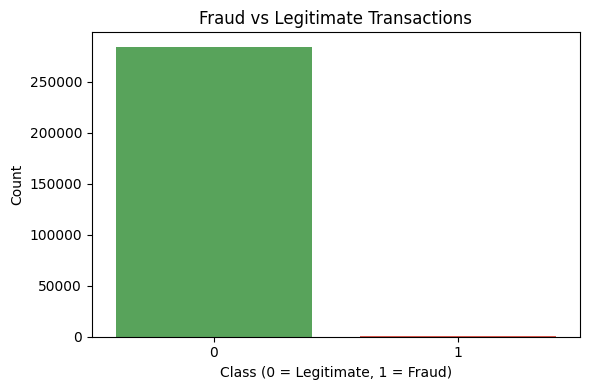

In [79]:
# Visualize Fraud Distribution
plt.figure(figsize=(6,4))

sns.countplot(x='Class', data=df, palette=['#4CAF50', '#F44336'])

plt.title("Fraud vs Legitimate Transactions")
plt.xlabel("Class (0 = Legitimate, 1 = Fraud)")
plt.ylabel("Count")

plt.tight_layout()
plt.show()

In [80]:
df["Class"].value_counts() #Unbalanced 

Class
0    284315
1       492
Name: count, dtype: int64

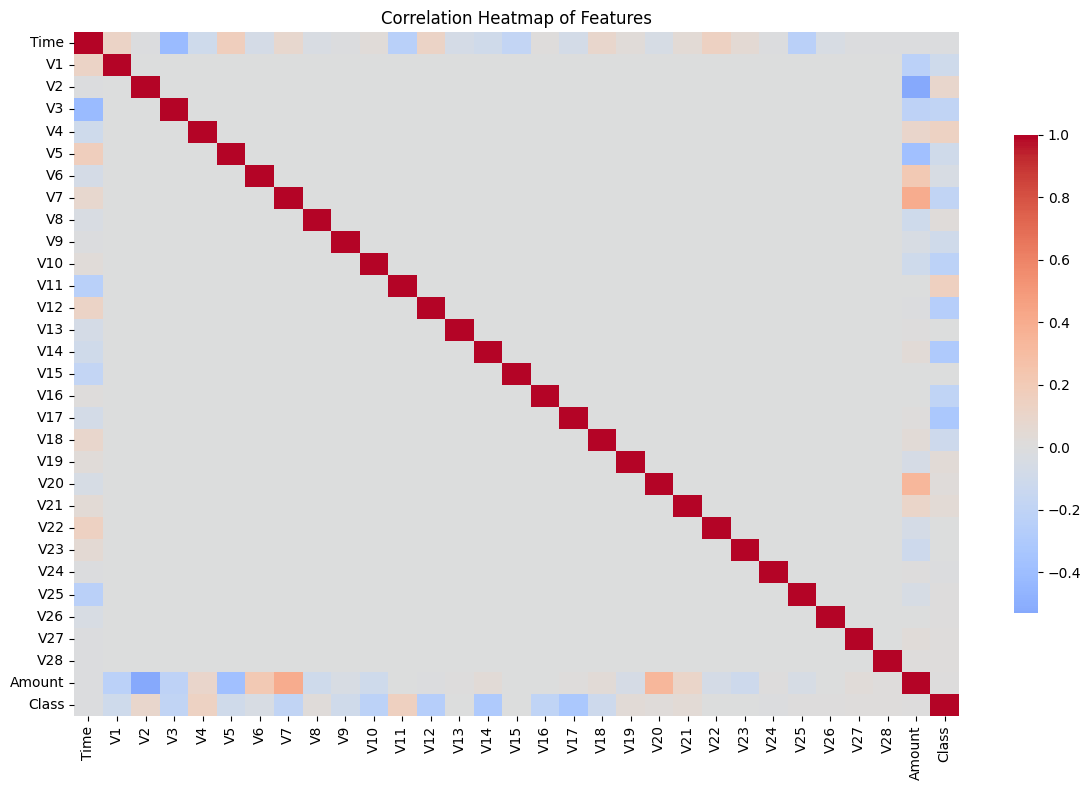

In [81]:
#Correlation Heatmap
corr = df.corr()

plt.figure(figsize=(12,8))

sns.heatmap(corr, cmap="coolwarm", center=0, cbar_kws={'shrink':0.7})
plt.title("Correlation Heatmap of Features")

plt.tight_layout()
plt.show()

<Axes: >

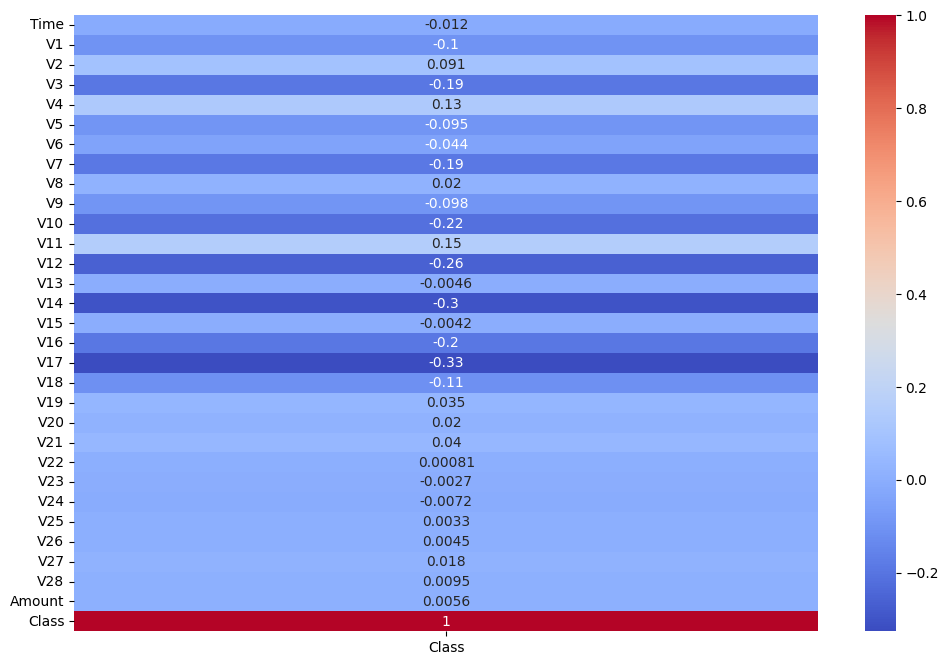

In [82]:
plt.figure(figsize=(12,8))
sns.heatmap(df.corr()['Class'].to_frame(), annot=True, cmap='coolwarm')

In [85]:
#Take a copy 
#df1 = df.copy()

In [86]:
# Define features (X) and target (y)
X = df.drop('Class', axis=1)
y = df['Class']

# Split the data into train and test 
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

print(f"Train set: {X_train.shape[0]} samples, Fraud cases: {y_train.sum()}")
print(f"Test set:  {X_test.shape[0]} samples, Fraud cases: {y_test.sum()}")

Train set: 227845 samples, Fraud cases: 394
Test set:  56962 samples, Fraud cases: 98


In [87]:
# Scale 'Amount' and 'Time'
scaler_amount = StandardScaler()
scaler_time = StandardScaler()

# Fit on Train 
X_train['scaled_amount'] = scaler_amount.fit_transform(X_train[['Amount']])
X_test['scaled_amount'] = scaler_amount.transform(X_test[['Amount']])

X_train['scaled_time'] = scaler_time.fit_transform(X_train[['Time']])
X_test['scaled_time'] = scaler_time.transform(X_test[['Time']])

In [88]:
# Hour of day + time bins
def create_time_features(df):
    df['hour_of_day'] = (df['Time'] % 86400) // 3600
    df['time_bin'] = pd.cut(df['hour_of_day'], 
                            bins=[0,6,12,18,24],
                            labels=['night','morning','afternoon','evening'],
                            include_lowest=True)
    return df

X_train = create_time_features(X_train)
X_test = create_time_features(X_test)

In [89]:
# amount deviation for normal transactions
normal_mean = X_train[y_train == 0]['scaled_amount'].mean()

X_train['amount_deviation'] = X_train['scaled_amount'] - normal_mean
X_test['amount_deviation']  = X_test['scaled_amount']  - normal_mean

# qcut

# First qcut to get intervals
temp_qcuts = pd.qcut(X_train['scaled_amount'], q=4)

# Extract bin edges 
bin_edges = [temp_qcuts.cat.categories[0].left] + [interval.right for interval in temp_qcuts.cat.categories]

# Second qcut with labels 
X_train['amount_bin'] = pd.qcut(X_train['scaled_amount'], q=4, labels=['low','medium','high','very_high'])

# Apply to test using the bin edges
X_test['amount_bin'] = pd.cut(X_test['scaled_amount'], bins=bin_edges,
    labels=['low','medium','high','very_high'], include_lowest=True)

In [90]:
# One-hot encode categories
X_train = pd.get_dummies(X_train, columns=['time_bin','amount_bin'], drop_first=True)
X_test = pd.get_dummies(X_test, columns=['time_bin','amount_bin'], drop_first=True)

# Make test match train columns
X_test = X_test.reindex(columns=X_train.columns, fill_value=0)

In [91]:
# V features m/stdev + interactions
v_columns = [f'V{i}' for i in range(1, 29)]

X_train['mean_V'] = X_train[v_columns].mean(axis=1)
X_test['mean_V'] = X_test[v_columns].mean(axis=1)

X_train['std_V'] = X_train[v_columns].std(axis=1)
X_test['std_V'] = X_test[v_columns].std(axis=1)

In [92]:
# correlation only on train
numerical_cols = ['scaled_time','scaled_amount','hour_of_day','amount_deviation',
                  'mean_V','std_V'] + v_columns

corr = X_train[numerical_cols].corrwith(y_train).abs().sort_values(ascending=False)
top_corr_features = corr[:4].index.tolist()

In [93]:
# interaction on train
for i, f1 in enumerate(top_corr_features[:2]):
    for f2 in top_corr_features[i+1:3]:
        X_train[f'{f1}_{f2}_interaction'] = X_train[f1] * X_train[f2]
        X_test[f'{f1}_{f2}_interaction'] = X_test[f1] * X_test[f2]

In [94]:
# Drop original Time & Amount
X_train.drop(['Time','Amount'], axis=1, inplace=True)
X_test.drop(['Time','Amount'], axis=1, inplace=True)

In [95]:
X_train.head()

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,time_bin_afternoon,time_bin_evening,amount_bin_medium,amount_bin_high,amount_bin_very_high,mean_V,std_V,V17_mean_V_interaction,V17_V14_interaction,mean_V_V14_interaction
265518,1.946747,-0.752526,-1.355130,-0.661630,1.502822,4.024933,-1.479661,1.139880,1.406819,-0.157403,...,False,True,True,False,False,0.255592,1.100494,-0.195699,0.050959,-0.017011
180305,2.035149,-0.048880,-3.058693,0.247945,2.943487,3.298697,-0.002192,0.674782,0.045826,0.284864,...,False,False,False,False,False,0.193619,1.151014,-0.052440,-0.195296,0.139613
42664,-0.991920,0.603193,0.711976,-0.992425,-0.825838,1.956261,-2.212603,-5.037523,0.000772,-2.009561,...,False,False,False,False,True,-0.302856,1.490767,0.219454,-0.088944,-0.037174
198723,2.285718,-1.500239,-0.747565,-1.668119,-1.394143,-0.350339,-1.427984,0.010010,-1.118447,1.756121,...,False,False,True,False,False,-0.229384,0.868236,-0.016695,-0.014213,0.044796
82325,-0.448747,-1.011440,0.115903,-3.454854,0.715771,-0.147490,0.504347,-0.113817,-0.044782,-0.558955,...,True,False,False,False,True,-0.337722,0.887593,0.134929,-0.053800,-0.045477


In [96]:
X_test.head()

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,time_bin_afternoon,time_bin_evening,amount_bin_medium,amount_bin_high,amount_bin_very_high,mean_V,std_V,V17_mean_V_interaction,V17_V14_interaction,mean_V_V14_interaction
263020,-0.674466,1.408105,-1.110622,-1.328366,1.388996,-1.308439,1.885879,-0.614233,0.311652,0.650757,...,False,True,False,True,False,0.005062,0.800215,-0.003065,-0.161319,0.001348
11378,-2.829816,-2.765149,2.537793,-1.074580,2.842559,-2.153536,-1.795519,-0.250020,3.073504,-1.000418,...,False,False,True,False,False,-0.110388,1.507911,0.023107,-0.201787,-0.106411
147283,-3.576495,2.318422,1.306985,3.263665,1.127818,2.865246,1.444125,-0.718922,1.874046,7.398491,...,False,False,False,True,False,0.586313,2.067652,-0.228899,0.948762,-1.424858
219439,2.060386,-0.015382,-1.082544,0.386019,-0.024331,-1.074935,0.207792,-0.338140,0.455091,0.047859,...,True,False,False,False,False,-0.030533,0.621576,0.008892,-0.046191,-0.004843
36939,1.209965,1.384303,-1.343531,1.763636,0.662351,-2.113384,0.854039,-0.475963,-0.629658,-1.579654,...,False,False,False,False,False,0.136558,1.290083,0.388635,-10.070704,-0.483227


In [97]:
def find_optimal_threshold(y_true, y_proba, beta=2.0):
    precisions, recalls, thresholds = precision_recall_curve(y_true, y_proba)

    # thresholds length = n-1
    thresholds = np.append(thresholds, 1.0)
    
    # Compute F-beta score
    f_scores = (1 + beta**2) * (precisions * recalls) / (beta**2 * precisions + recalls + 1e-10)

    best_idx = np.argmax(f_scores)
    return thresholds[best_idx], f_scores[best_idx]

In [98]:
def evaluate_model(model, X_test, y_test, model_name, threshold=0.5):
    # Probability predictions (for ROC-AUC and PR-AUC)
    y_proba = model.predict_proba(X_test)[:, 1]
    # Binary predictions with threshold
    y_pred = (y_proba >= threshold).astype(int)

    print(f"\n{'='*50}")
    print(f"=== {model_name} ===")
    print(f"{'='*50}")
    
    print(f"Classification Report:")
    print(classification_report(y_test, y_pred, target_names=['Legit', 'Fraud'], digits=4))

    # Metrics
    roc_auc = roc_auc_score(y_test, y_proba)
    
    precision, recall, _ = precision_recall_curve(y_test, y_proba)
    pr_auc = auc(recall, precision) # Precision-Recall Curve (AUPRC)
    
    f1 = f1_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred, zero_division=0)
    rec = recall_score(y_test, y_pred)
    acc = accuracy_score(y_test, y_pred)

    print(f"\nKey Metrics:")
    print(f"   Accuracy:  {acc:.4f}")
    print(f"   ROC-AUC:   {roc_auc:.4f}")
    print(f"   PR-AUC:    {pr_auc:.4f}")
    print(f"   F1-Score:  {f1:.4f}")
    print(f"   Precision: {prec:.4f}")
    print(f"   Recall:    {rec:.4f}")

    # Confusion Matrix
    plt.figure(figsize=(6, 5))
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['Legit', 'Fraud'],
                yticklabels=['Legit', 'Fraud'])
    plt.title(f'Confusion Matrix - {model_name}')
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.show()

    return {
        'Accuracy': acc,
        'ROC-AUC': roc_auc,
        'PR-AUC': pr_auc,
        'F1': f1,
        'Precision': prec,
        'Recall': rec,
        'y_proba': y_proba
    }


Performing 5-fold cross-validation...

Fold 1/5
Fold 1 Metrics: PR-AUC=0.8597, F1=0.8571, Accuracy : 0.9995 ,Precision=0.8684, Recall=0.8462, Threshold=0.1201

Fold 2/5
Fold 2 Metrics: PR-AUC=0.8163, F1=0.8101, Accuracy : 0.9993 ,Precision=0.8101, Recall=0.8101, Threshold=0.0340

Fold 3/5
Fold 3 Metrics: PR-AUC=0.8274, F1=0.7765, Accuracy : 0.9992 ,Precision=0.7253, Recall=0.8354, Threshold=0.0093

Fold 4/5
Fold 4 Metrics: PR-AUC=0.8900, F1=0.8589, Accuracy : 0.9995 ,Precision=0.8333, Recall=0.8861, Threshold=0.4740

Fold 5/5
Fold 5 Metrics: PR-AUC=0.8433, F1=0.8828, Accuracy : 0.9996 ,Precision=0.9697, Recall=0.8101, Threshold=0.9977

Cross-Validation Results (Stacking Ensemble + SMOTE)
Accuracy     0.9994
ROC-AUC      0.9819
PR-AUC       0.8473
F1           0.8371
Precision    0.8414
Recall       0.8376
Threshold    0.3270
dtype: float64

Std of Metrics:
Accuracy     0.0002
ROC-AUC      0.0086
PR-AUC       0.0289
F1           0.0429
Precision    0.0890
Recall       0.0314
Threshold 

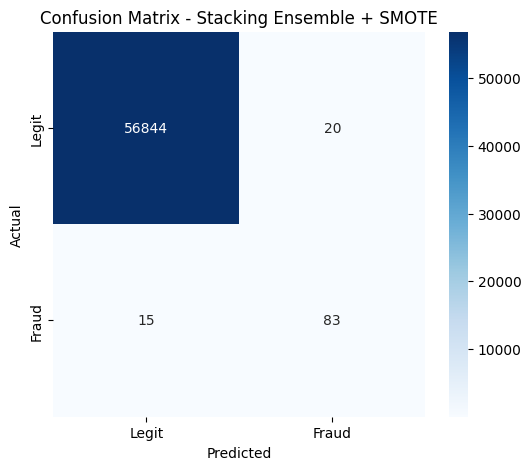


Optimal Threshold: 0.8923 (Max F1=0.8539)

=== Stacking Ensemble + SMOTE (Optimized Threshold) ===
Classification Report:
              precision    recall  f1-score   support

       Legit     0.9997    0.9998    0.9998     56864
       Fraud     0.8830    0.8469    0.8646        98

    accuracy                         0.9995     56962
   macro avg     0.9414    0.9234    0.9322     56962
weighted avg     0.9995    0.9995    0.9995     56962


Key Metrics:
   Accuracy:  0.9995
   ROC-AUC:   0.9831
   PR-AUC:    0.8679
   F1-Score:  0.8646
   Precision: 0.8830
   Recall:    0.8469


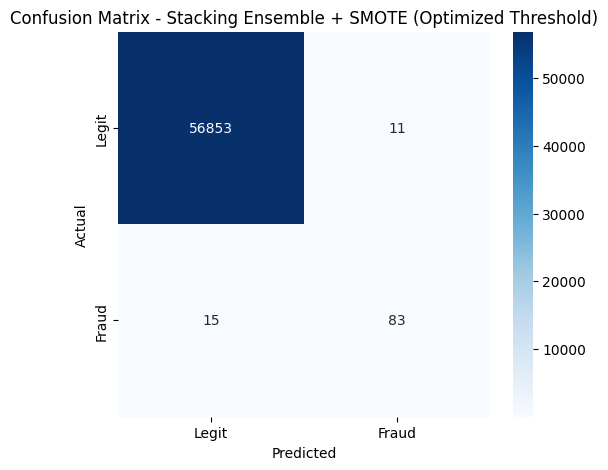

{'Accuracy': 0.9995435553526912,
 'ROC-AUC': 0.9830571402731042,
 'PR-AUC': 0.8679220955038783,
 'F1': 0.8645833333333334,
 'Precision': 0.8829787234042553,
 'Recall': 0.8469387755102041,
 'y_proba': array([0.00031379, 0.0003135 , 0.00031807, ..., 0.00031348, 0.00031361,
        0.00031714])}

In [99]:
base_models = [
    ('xgb', xgb.XGBClassifier(n_estimators=100, max_depth=5, learning_rate=0.1, random_state=42, n_jobs=-1)),
    ('cat', CatBoostClassifier(iterations=100, depth=5, learning_rate=0.1, random_state=42, verbose=0)),
    ('lgb', lgb.LGBMClassifier(n_estimators=100, max_depth=7, learning_rate=0.1, random_state=42, n_jobs=-1, min_child_samples=10,verbose=-1))
]

meta_model = LogisticRegression(random_state=42)
stacking_classifier = StackingClassifier(estimators=base_models,
                                         final_estimator=meta_model,
                                         cv=5)


stacking_smote_pipeline = ImbPipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('smote', SMOTE(sampling_strategy=0.1, random_state=42)),
    ('classifier', stacking_classifier)
])

# Cross validation results 
cv_results = {
    'Accuracy':[],
    'ROC-AUC': [],
    'PR-AUC': [],
    'F1': [],
    'Precision': [],
    'Recall': [],
    'Threshold': []
}

print("\nPerforming 5-fold cross-validation...")

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
for fold, (train_idx, val_idx) in enumerate(skf.split(X_train, y_train), 1):
    print(f"\nFold {fold}/5")
    
    X_tr = X_train.iloc[train_idx]
    X_val = X_train.iloc[val_idx]
    y_tr = y_train.iloc[train_idx]
    y_val = y_train.iloc[val_idx]


    stacking_smote_pipeline.fit(X_tr, y_tr)

    # predictions
    y_proba = stacking_smote_pipeline.predict_proba(X_val)[:, 1]

    # best threshold
    opt_thresh, opt_f1 = find_optimal_threshold(y_val, y_proba, beta=2.0)
    y_pred = (y_proba >= opt_thresh).astype(int)

    # metrics
    Accuracy = accuracy_score(y_val,y_pred)
    roc_auc = roc_auc_score(y_val, y_proba)
    
    precision, recall, _ = precision_recall_curve(y_val, y_proba)
    pr_auc = auc(recall, precision)
    
    f1 = f1_score(y_val, y_pred)
    prec = precision_score(y_val, y_pred, zero_division=0)
    rec = recall_score(y_val, y_pred)
    
    cv_results['Accuracy'].append(Accuracy)
    cv_results['ROC-AUC'].append(roc_auc)
    cv_results['PR-AUC'].append(pr_auc)
    cv_results['F1'].append(f1)
    cv_results['Precision'].append(prec)
    cv_results['Recall'].append(rec)
    cv_results['Threshold'].append(opt_thresh)

    print(f"Fold {fold} Metrics: PR-AUC={pr_auc:.4f}, F1={f1:.4f}, Accuracy : {Accuracy:.4f} ,Precision={prec:.4f}, Recall={rec:.4f}, Threshold={opt_thresh:.4f}")


cv_results_df = pd.DataFrame(cv_results)
print("\n" + "="*80)
print("Cross-Validation Results (Stacking Ensemble + SMOTE)")
print("="*80)
print(cv_results_df.mean().round(4))
print("\nStd of Metrics:")
print(cv_results_df.std().round(4))

# Train Final Model
print("\nTraining model on full training set...")
stacking_smote_pipeline.fit(X_train, y_train)


metrics = evaluate_model(stacking_smote_pipeline, X_test, y_test, 'Stacking Ensemble + SMOTE', threshold=0.5)

# optimal threshold on test
y_proba_best = stacking_smote_pipeline.predict_proba(X_test)[:, 1]
opt_thresh, opt_f1 = find_optimal_threshold(y_test, y_proba_best, beta=2.0)

print(f"\nOptimal Threshold: {opt_thresh:.4f} (Max F1={opt_f1:.4f})")

evaluate_model(
    stacking_smote_pipeline, X_test, y_test,
    "Stacking Ensemble + SMOTE (Optimized Threshold)",
    threshold=opt_thresh
)

In [100]:
import joblib

joblib.dump(stacking_smote_pipeline, "fraud_pipeline.pkl")
joblib.dump(scaler_amount, "scaler_amount.pkl")
joblib.dump(scaler_time, "scaler_time.pkl")
joblib.dump(bin_edges, "bin_edges.pkl")
joblib.dump(X_train.columns.tolist(), "feature_columns.pkl")

['feature_columns.pkl']

# Bonus Code

In [101]:
df=pd.read_csv('/kaggle/input/fraud-detection/creditcard.csv')
df.shape

(284807, 31)

In [102]:
scaler = StandardScaler()
df["Amount"] = scaler.fit_transform(df["Amount"].values.reshape(-1, 1))
df["Time"] = scaler.fit_transform(df["Time"].values.reshape(-1, 1))

In [103]:
# working without time this try
df = df.drop(["Time"], axis=1)

In [104]:
X = df.drop("Class", axis=1)
y = df["Class"]

In [105]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [106]:
print("Shape of X_train:",X_train.shape)
print("Shape of y_train:",y_train.shape)
print("Shape of X_test:", X_test.shape) 
print("Shape of y_test:",y_test.shape)

Shape of X_train: (227845, 29)
Shape of y_train: (227845,)
Shape of X_test: (56962, 29)
Shape of y_test: (56962,)


In [107]:
def evaluate_model(X_train, y_train, X_test, y_test, model, name):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    y_prob = model.predict_proba(X_test)[:, 1]
    
    print(f"\n=== {name} ===")
    print("Classification Report:")
    print(classification_report(y_test, y_pred))
    
    print("Confusion Matrix:")
    print(confusion_matrix(y_test, y_pred))
    
    print(f"ROC AUC Score: {roc_auc_score(y_test, y_prob):.4f}")
    precision, recall, _ = precision_recall_curve(y_test, y_prob)
    pr_auc = auc(recall, precision)
    print(f"Precision-Recall AUC: {pr_auc:.4f}")
    return y_pred, y_prob

In [108]:
base_model = LogisticRegression(solver='liblinear', random_state=42)
print("\n--- Base Model Performance (No Resampling) ---")
evaluate_model(X_train, y_train, X_test, y_test, base_model, 'Base Model')


--- Base Model Performance (No Resampling) ---

=== Base Model ===
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.83      0.64      0.72        98

    accuracy                           1.00     56962
   macro avg       0.91      0.82      0.86     56962
weighted avg       1.00      1.00      1.00     56962

Confusion Matrix:
[[56851    13]
 [   35    63]]
ROC AUC Score: 0.9574
Precision-Recall AUC: 0.7424


(array([0, 0, 0, ..., 0, 0, 0]),
 array([5.02704475e-05, 5.25920627e-05, 1.23560371e-06, ...,
        2.59180607e-05, 6.27766158e-05, 2.31826069e-04]))

In [109]:
# TomekLinks
print("\n--- TomekLinks ---")
tl = TomekLinks(sampling_strategy='majority')
X_resampled_tl, y_resampled_tl = tl.fit_resample(X_train, y_train)
print("Shape after TomekLinks: {}\n".format(X_resampled_tl.shape))
print("Class distribution after TomekLinks:")
print(pd.Series(y_resampled_tl).value_counts())
evaluate_model(X_resampled_tl, y_resampled_tl, X_test, y_test, LogisticRegression(solver='liblinear', random_state=42), 'TomekLinks')


--- TomekLinks ---
Shape after TomekLinks: (227822, 29)

Class distribution after TomekLinks:
Class
0    227428
1       394
Name: count, dtype: int64

=== TomekLinks ===
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.83      0.65      0.73        98

    accuracy                           1.00     56962
   macro avg       0.92      0.83      0.87     56962
weighted avg       1.00      1.00      1.00     56962

Confusion Matrix:
[[56851    13]
 [   34    64]]
ROC AUC Score: 0.9577
Precision-Recall AUC: 0.7424


(array([0, 0, 0, ..., 0, 0, 0]),
 array([4.93146064e-05, 5.40639680e-05, 1.12898453e-06, ...,
        2.57142610e-05, 6.10444961e-05, 2.40152680e-04]))

In [110]:
# SMOTE
print("\n--- SMOTE ---")
sm = SMOTE(random_state=42)
X_resampled_sm, y_resampled_sm = sm.fit_resample(X_train, y_train)
print("Shape after SMOTE: {}\n".format(X_resampled_sm.shape))
print("Class distribution after SMOTE:")
print(pd.Series(y_resampled_sm).value_counts())
evaluate_model(X_resampled_sm, y_resampled_sm, X_test, y_test, LogisticRegression(solver='liblinear', random_state=42), 'SMOTE')


--- SMOTE ---
Shape after SMOTE: (454902, 29)

Class distribution after SMOTE:
Class
0    227451
1    227451
Name: count, dtype: int64

=== SMOTE ===
Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.97      0.99     56864
           1       0.06      0.92      0.11        98

    accuracy                           0.97     56962
   macro avg       0.53      0.95      0.55     56962
weighted avg       1.00      0.97      0.98     56962

Confusion Matrix:
[[55348  1516]
 [    8    90]]
ROC AUC Score: 0.9700
Precision-Recall AUC: 0.7680


(array([0, 0, 0, ..., 0, 0, 0]),
 array([4.32251435e-03, 4.47673910e-02, 7.71540540e-05, ...,
        4.08662268e-04, 1.31501771e-03, 5.10782905e-02]))

In [111]:
# ADASYN
print("\n--- ADASYN ---")
ada = ADASYN(random_state=42)
X_resampled_ada, y_resampled_ada = ada.fit_resample(X_train, y_train)
print("Shape after ADASYN: {}\n".format(X_resampled_ada.shape))
print("Class distribution after ADASYN:")
print(pd.Series(y_resampled_ada).value_counts())
evaluate_model(X_resampled_ada, y_resampled_ada, X_test, y_test, LogisticRegression(solver='liblinear', random_state=42), 'ADASYN')


--- ADASYN ---
Shape after ADASYN: (454909, 29)

Class distribution after ADASYN:
Class
1    227458
0    227451
Name: count, dtype: int64

=== ADASYN ===
Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.91      0.95     56864
           1       0.02      0.93      0.04        98

    accuracy                           0.91     56962
   macro avg       0.51      0.92      0.49     56962
weighted avg       1.00      0.91      0.95     56962

Confusion Matrix:
[[51914  4950]
 [    7    91]]
ROC AUC Score: 0.9720
Precision-Recall AUC: 0.7951


(array([0, 0, 0, ..., 0, 0, 0]),
 array([3.04823460e-03, 1.21248896e-01, 2.18625725e-06, ...,
        2.70879872e-04, 3.93030053e-03, 1.43356522e-01]))

In [112]:
# Logistic Regression after setting class weight
print("\n--- Logistic Regression (with Class Weight) ---")

# Calculate class weights (e.g., inversely proportional to class frequencies)
# This is a common way to set class weights for imbalanced data
class_weights = {0: 1, 1: (y_train.value_counts()[0] / y_train.value_counts()[1])}
print(f"Calculated Class Weights: {class_weights}")

cs_model = LogisticRegression(solver='liblinear', class_weight=class_weights, random_state=42)
evaluate_model(X_train, y_train, X_test, y_test, cs_model, 'Cost-Sensitive Logistic Regression')


--- Logistic Regression (with Class Weight) ---
Calculated Class Weights: {0: 1, 1: 577.2868020304569}

=== Cost-Sensitive Logistic Regression ===
Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.97      0.99     56864
           1       0.06      0.92      0.11        98

    accuracy                           0.97     56962
   macro avg       0.53      0.95      0.55     56962
weighted avg       1.00      0.97      0.99     56962

Confusion Matrix:
[[55422  1442]
 [    8    90]]
ROC AUC Score: 0.9714
Precision-Recall AUC: 0.7633


(array([0, 0, 0, ..., 0, 0, 0]),
 array([0.00581265, 0.05871101, 0.00010387, ..., 0.00039394, 0.00489947,
        0.08294612]))

**SEE THE DIFFERENCE:**
- before setting class weights = 
  - ROC AUC Score: 0.9574
  - Precision-Recall AUC: 0.7424
- after setting class weights =
  - ROC AUC Score: 0.9714
  - Precision-Recall AUC: 0.7633

In [113]:
from imblearn.pipeline import Pipeline

In [114]:
# Pipeline: SMOTE + Logistic Regression
print("\n--- SMOTE + Logistic Regression Pipeline ---")
pipeline_sm_lr = Pipeline([('smote', SMOTE(random_state=42)),
                           ('classifier', LogisticRegression(solver='liblinear', random_state=42))])
evaluate_model(X_train, y_train, X_test, y_test, pipeline_sm_lr, 'SMOTE + Logistic Regression Pipeline')


--- SMOTE + Logistic Regression Pipeline ---

=== SMOTE + Logistic Regression Pipeline ===
Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.97      0.99     56864
           1       0.06      0.92      0.11        98

    accuracy                           0.97     56962
   macro avg       0.53      0.95      0.55     56962
weighted avg       1.00      0.97      0.98     56962

Confusion Matrix:
[[55348  1516]
 [    8    90]]
ROC AUC Score: 0.9700
Precision-Recall AUC: 0.7680


(array([0, 0, 0, ..., 0, 0, 0]),
 array([4.32251435e-03, 4.47673910e-02, 7.71540540e-05, ...,
        4.08662268e-04, 1.31501771e-03, 5.10782905e-02]))

In [115]:
from sklearn.ensemble import RandomForestClassifier

In [116]:
print("\n--- RandomForestClassifier with Class Weight ---")
rf_cs_model = RandomForestClassifier(class_weight=class_weights, random_state=42)
evaluate_model(X_train, y_train, X_test, y_test, rf_cs_model, 'RandomForestClassifier with Class Weight')


--- RandomForestClassifier with Class Weight ---

=== RandomForestClassifier with Class Weight ===
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.96      0.76      0.85        98

    accuracy                           1.00     56962
   macro avg       0.98      0.88      0.92     56962
weighted avg       1.00      1.00      1.00     56962

Confusion Matrix:
[[56861     3]
 [   24    74]]
ROC AUC Score: 0.9580
Precision-Recall AUC: 0.8547


(array([0, 0, 0, ..., 0, 0, 0]), array([0., 0., 0., ..., 0., 0., 0.]))

In [117]:
# Pipeline: SMOTE + RandomForestClassifier
print("\n--- SMOTE + RandomForestClassifier Pipeline ---")
pipeline_sm_rf = Pipeline([('smote', SMOTE(random_state=42)),
                           ('classifier', RandomForestClassifier(random_state=42))])
evaluate_model(X_train, y_train, X_test, y_test, pipeline_sm_rf, 'SMOTE + RandomForestClassifier Pipeline')


--- SMOTE + RandomForestClassifier Pipeline ---

=== SMOTE + RandomForestClassifier Pipeline ===
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.87      0.83      0.85        98

    accuracy                           1.00     56962
   macro avg       0.94      0.91      0.92     56962
weighted avg       1.00      1.00      1.00     56962

Confusion Matrix:
[[56852    12]
 [   17    81]]
ROC AUC Score: 0.9731
Precision-Recall AUC: 0.8741


(array([0, 0, 0, ..., 0, 0, 0]), array([0., 0., 0., ..., 0., 0., 0.]))